In [1]:
import os
import numpy as np
import xarray as xr
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# from holodecml.data import load_unet_datasets_xy


/glade/u/home/ggantos/miniconda3/envs/micro/lib/python3.6/site-packages/distributed/config.py:63: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config.update(yaml.load(text))


In [2]:
def makeGaussian(size, fwhm = 3, center=None):
    """ Make a square gaussian kernel.

    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """

    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]

    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]

    return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)

(9, 9)


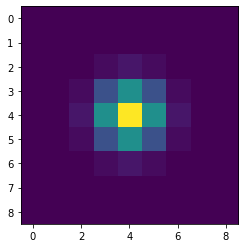

In [67]:
r = 2
gauss = makeGaussian(9, r, center=None)
print(gauss.shape)
plt.imshow(gauss)


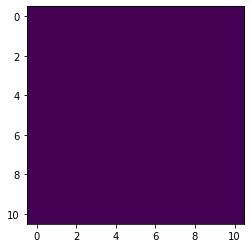

In [4]:
base = np.zeros((11,11))
plt.imshow(base)


In [5]:
base[cp[0]-r:cp[0]+1+r, cp[1]-r:cp[1]+1+r] += gauss

NameError: name 'cp' is not defined

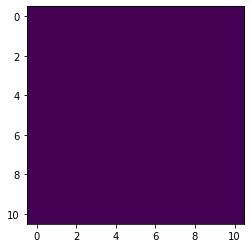

In [7]:
cp = (5,5)
plt.imshow(base)


In [8]:
gauss

array([[0.00390625, 0.03125   , 0.0625    , 0.03125   , 0.00390625],
       [0.03125   , 0.25      , 0.5       , 0.25      , 0.03125   ],
       [0.0625    , 0.5       , 1.        , 0.5       , 0.0625    ],
       [0.03125   , 0.25      , 0.5       , 0.25      , 0.03125   ],
       [0.00390625, 0.03125   , 0.0625    , 0.03125   , 0.00390625]])

In [9]:
gauss/np.sum(gauss)

array([[0.00086505, 0.00692042, 0.01384083, 0.00692042, 0.00086505],
       [0.00692042, 0.05536332, 0.11072664, 0.05536332, 0.00692042],
       [0.01384083, 0.11072664, 0.22145329, 0.11072664, 0.01384083],
       [0.00692042, 0.05536332, 0.11072664, 0.05536332, 0.00692042],
       [0.00086505, 0.00692042, 0.01384083, 0.00692042, 0.00086505]])

In [10]:
np.sum(gauss/np.sum(gauss))

0.9999999999999999

In [2]:
path_data = "/glade/p/cisl/aiml/ai4ess_hackathon/holodec/"
num_particles = "12-25"
output_cols = ["x", "y", "z", "d", "hid"]
subset = 0.01
scaler_out = MinMaxScaler()
bin_factor = 10
gauss_size = 5
gauss_rad = 2
input_col="image"


In [12]:
num_particles_dict = {
    1 : ['1particle_gamma_600x400'],
    2 : ['2particle_gamma_600x400'],
    3 : ['3particle_gamma_600x400'],
    4 : ['4particle_gamma_600x400'],
    5 : ['5particle_gamma_600x400'],
    6 : ['6particle_gamma_600x400'],
    7 : ['7particle_gamma_600x400'],
    8 : ['8particle_gamma_600x400'],
    9 : ['9particle_gamma_600x400'],
    10 : ['10particle_gamma_600x400'],
    '1-3': ['multiparticle'],
    '12-25': ['12-25particle_gamma_600x400'],
    '50-100': ['50-100particle_gamma'],
    'patches': ['10particle_gamma_512x512','patches128x128']
}

split_dict = {
    'train' : 'training',
    'test' : 'test',
    'valid' : 'validation'}


In [13]:
def dataset_name(num_particles, split, file_extension='nc'):
    """
    Return the dataset filename given user inputs
    
    Args: 
        num_particles: (int or str) Number of particles per hologram
        split: (str) Dataset split of either 'train', 'valid', or 'test'
        file_extension: (str) Dataset file extension
    
    Returns:
        ds_name: (str) Dataset name
    """
    
    valid = [1,2,3,4,5,6,7,8,9,10,'1-3','12-25','50-100','patches']
    if num_particles not in valid:
        raise ValueError("results: num_particles must be one of %r." % valid)
    num_particles = num_particles_dict[num_particles]

    valid = ['train','test','valid']
    if split not in valid:
        raise ValueError("results: split must be one of %r." % valid)
    split = split_dict[split]
    if len(num_particles) > 1:
        ds_name = f'synthetic_holograms_{num_particles[0]}_{split}_{num_particles[1]}.{file_extension}'
    else:
        ds_name = f'synthetic_holograms_{num_particles[0]}_{split}.{file_extension}'
    
    return ds_name


In [14]:
def load_raw_datasets(path_data, num_particles, split, output_cols, subset, input_col="image"):
    """
    Given a path to training or validation datset, the number of particles per
    hologram, and output columns, returns raw inputs and outputs. Can specify
    a subset of the full dataset.
    
    Args: 
        path_data: (str) Path to dataset directory
        num_particles: (int or str) Number of particles per hologram 
        split: (str) Dataset split of either 'train', 'valid', or 'test'
        subset: (float or int) Fraction or int of data to be loaded
        output_cols: (list of strings) List of feature columns
        
    Returns:
        inputs: (np array) Input image data
        outputs: (df) Output data specified by output_cols 
    """
    
    ds = open_dataset(path_data, num_particles, split)
    if subset:
        if int(subset) < 1.0:
            ix = int(subset * ds[input_col].shape[0])
        else:
            ix = subset
        outputs = ds[output_cols].to_dataframe()
        outputs = outputs[outputs["hid"] < (ix+1)]
        if input_col == "patch":
            multiplier = int(ds["patch"].shape[0] // ds["image"].shape[0])
            ix *= multiplier
        inputs = ds[input_col][:ix].values
    else:
        inputs = ds[input_col].values
        outputs = ds[output_cols].to_dataframe()    
    ds.close()
    return inputs, outputs


In [15]:
def scale_images(images, scaler_in=None):
    """
    Takes in array of images and scales pixel values between 0 and 1
    
    Args: 
        images: (np array) Input image data
        scaler_in: (dict) Image scaler 'max' and 'min' values
        
    Returns:
        images_scaled: (np array) Input image data scaled between 0 and 1
        scaler_in: (dict) Image scaler 'max' and 'min' values
    """
    
    if scaler_in is None:
        scaler_in = {}
        scaler_in["min"] = images.min()
        scaler_in["max"] = images.max()
    images_scaled = (images.astype(np.float32) - scaler_in["min"])
    images_scaled /= (scaler_in["max"] - scaler_in["min"])

    return images_scaled, scaler_in
    

In [16]:
def open_dataset(path_data, num_particles, split):
    """
    Opens a HOLODEC file
    
    Args: 
        path_data: (str) Path to dataset directory
        num_particles: (int or str) Number of particles per hologram
        split: (str) Dataset split of either 'train', 'valid', or 'test'
    
    Returns:
        ds: (xarray Dataset) Opened dataset
    """
    path_data = os.path.join(path_data, dataset_name(num_particles, split))
    ds = xr.open_dataset(path_data)
    return ds


In [17]:
# def unet_bin_xy(inputs, outputs, bin_factor):
    
#     if not bin_factor:
#         num_bins_x = inputs.shape[1]
#         num_bins_y = inputs.shape[2]
#     else:
#         num_bins_x = inputs.shape[1] // bin_factor
#         num_bins_y = inputs.shape[2] // bin_factor
    
#     unet_outputs = []
#     for hid in outputs["hid"].unique():
#         outputs_hid = outputs.loc[outputs['hid'] == hid]
#         x_linspace, y_linspace = get_linspace(inputs[0].shape, (num_bins_x, num_bins_y))
#         xs_hid = np.digitize(outputs_hid['x'], x_linspace)
#         ys_hid = np.digitize(outputs_hid['y'], y_linspace)

#         #sort coordinates on first x-axis then y-axis
#         coords_hid = np.array(list(zip(xs_hid,ys_hid)))
#         coords_hid = coords_hid[np.lexsort((coords_hid[:,1], coords_hid[:,0]))]
#         unique, unique_idx, unique_counts = np.unique(coords_hid, return_index=True, return_counts=True, axis=0)
#         # create three images and stack together
#         xy = np.zeros((num_bins_x, num_bins_y))
#         xy[unique[:, 0], unique[:, 1]] = 1
#         unet_outputs.append(np.expand_dims(xy, axis=-1))
#     unet_outputs = np.stack(unet_outputs, axis=0)
#     return unet_outputs


In [18]:
def get_linspace(input_shape, num_bins=False):
    if num_bins:
        num_bins_x, num_bins_y = num_bins
    else:
        num_bins_x = input_shape[0]
        num_bins_y = input_shape[1]

    if input_shape == (600, 400):
        return np.linspace(-888, 888, num_bins_x), np.linspace(-592, 592, num_bins_y)
    if input_shape == (512, 512):
        return np.linspace(-757, 757, num_bins_x), np.linspace(-757, 757, num_bins_y)
    if input_shape == (1200, 800):
        return np.linspace(-1776, 1776, num_bins_x), np.linspace(-1776, 1776, num_bins_y)
    

In [29]:
def load_unet_datasets_xy(path_data, num_particles, output_cols,
                          subset=False, bin_factor=False, input_col="image",
                          gauss=False):
    
    train_inputs,\
    train_outputs = load_raw_datasets(path_data, num_particles, 'train',
                                      output_cols, subset, input_col=input_col)
    valid_inputs,\
    valid_outputs = load_raw_datasets(path_data, num_particles, 'valid',
                                      output_cols, subset, input_col=input_col)
    
    train_inputs, scaler_in = scale_images(train_inputs)
    valid_inputs, _ = scale_images(valid_inputs, scaler_in)
    
    train_outputs = unet_bin_xy(train_inputs, train_outputs, bin_factor, gauss)
    valid_outputs = unet_bin_xy(valid_inputs, valid_outputs, bin_factor, gauss)
    
    return train_inputs, train_outputs, valid_inputs, valid_outputs


In [68]:
def unet_bin_xy_gauss(inputs, outputs, bin_factor, gauss=False,
                      gauss_size = 5, gauss_rad = 2):
    
    if not bin_factor:
        num_bins_x = inputs.shape[1]
        num_bins_y = inputs.shape[2]
    else:
        num_bins_x = inputs.shape[1] // bin_factor
        num_bins_y = inputs.shape[2] // bin_factor
    
    if gauss in ["z","d"]:
        print(gauss)
        scaler = MinMaxScaler((2, 10))
        gauss_rads = outputs[gauss].to_numpy().reshape(-1, 1)
        outputs["gauss_rads"] = scaler.fit_transform(gauss_rads).astype(int) 
    if gauss == True:
        print("Gauss True")
        gaussarray = makeGaussian(gauss_size, gauss_rad)

    unet_outputs = []
    for hid in outputs["hid"].unique():
        outputs_hid = outputs.loc[outputs['hid'] == hid]
        x_linspace, y_linspace = get_linspace(inputs[0].shape, (num_bins_x, num_bins_y))
        xs_hid = np.digitize(outputs_hid['x'], x_linspace)
        ys_hid = np.digitize(outputs_hid['y'], y_linspace)

        #sort coordinates on first x-axis then y-axis
        coords_hid = np.array(list(zip(xs_hid,ys_hid,outputs_hid['gauss_rads'])))
        coords_hid = coords_hid[np.lexsort((coords_hid[:,1], coords_hid[:,0]))]
        unique, unique_idx, unique_counts = np.unique(coords_hid,
                                                      return_index=True,
                                                      return_counts=True,
                                                      axis=0)
        # create three images and stack together
        if gauss in ["z","d"]:
            max_gauss_rad = max(unique[:,2])
        else:
            max_gauss_rad = gauss_rad
        xy = np.zeros((num_bins_x + max_gauss_rad*2, num_bins_y + max_gauss_rad*2))
        for x,y,gauss_rad in unique:
            x_max = x + 1 + 2*gauss_rad
            y_max = y + 1 + 2*gauss_rad
            if gauss in ["z","d"]:
                gaussarray = makeGaussian(1+2*gauss_rad, gauss_rad)
            xy[x:x_max, y:y_max] += gaussarray
        xy = xy[max_gauss_rad:xy.shape[0]-max_gauss_rad,
                max_gauss_rad:xy.shape[1]-max_gauss_rad]
        unet_outputs.append(np.expand_dims(xy, axis=-1))
    unet_outputs = np.stack(unet_outputs, axis=0)
    
    return unet_outputs


In [69]:
train_inputs,\
train_outputs,\
valid_inputs,\
valid_outputs = load_unet_datasets_xy(path_data,
                                      num_particles,
                                      output_cols,
                                      subset,
                                      bin_factor,
                                      input_col,
                                      "z")

z
8 35 8
8 25
35 52
8 37 9
8 27
37 56
29 13 2
29 34
13 18
29 21 7
29 44
21 36
33 24 3
33 40
24 31
37 11 5
37 48
11 22
38 2 8
38 55
2 19
47 2 8
47 64
2 19
47 13 7
47 62
13 28
48 39 5
48 59
39 50
49 7 2
49 54
7 12
51 3 4
51 60
3 12
58 18 3
58 65
18 25
1 27 9
1 20
27 46
8 26 3
8 15
26 33
8 39 7
8 23
39 54
13 1 5
13 24
1 12
17 18 6
17 30
18 31
28 37 7
28 43
37 52
34 17 5
34 45
17 28
35 35 2
35 40
35 40
44 23 8
44 61
23 40
45 32 5
45 56
32 43
46 5 8
46 63
5 22
47 5 6
47 60
5 18
2 18 4
2 11
18 27
5 19 7
5 20
19 34
6 8 2
6 11
8 13
6 31 9
6 25
31 50
19 35 4
19 28
35 44
20 32 6
20 33
32 45
21 15 8
21 38
15 32
21 22 9
21 40
22 41
23 2 2
23 28
2 7
26 2 3
26 33
2 9
32 39 7
32 47
39 54
36 31 4
36 45
31 40
37 9 4
37 46
9 18
37 16 6
37 50
16 29
40 10 7
40 55
10 25
40 31 5
40 51
31 42
43 21 2
43 48
21 26
44 9 5
44 55
9 20
45 24 6
45 58
24 37
54 6 5
54 65
6 17
56 31 8
56 73
31 48
58 26 5
58 69
26 37
3 30 3
3 10
30 37
3 37 5
3 14
37 48
4 33 3
4 11
33 40
7 2 4
7 16
2 11
12 11 2
12 17
11 16
12 23 2
12 17


2 14 5
2 13
14 25
3 11 3
3 10
11 18
4 22 7
4 19
22 37
6 25 3
6 13
25 32
8 20 4
8 17
20 29
10 21 3
10 17
21 28
10 21 5
10 21
21 32
14 1 8
14 31
1 18
17 35 4
17 26
35 44
19 27 8
19 36
27 44
24 32 3
24 31
32 39
28 25 8
28 45
25 42
31 21 9
31 50
21 40
39 33 3
39 46
33 40
41 27 2
41 46
27 32
44 20 2
44 49
20 25
46 33 7
46 61
33 48
49 4 2
49 54
4 9
51 26 9
51 70
26 45
55 5 3
55 62
5 12
2 27 2
2 7
27 32
9 6 6
9 22
6 19
9 18 9
9 28
18 37
12 3 5
12 23
3 14
14 32 4
14 23
32 41
24 22 4
24 33
22 31
26 9 7
26 41
9 24
33 33 9
33 52
33 52
45 33 2
45 50
33 38
52 18 9
52 71
18 37
53 28 4
53 62
28 37
55 28 3
55 62
28 35
5 39 4
5 14
39 48
14 15 6
14 27
15 28
16 1 5
16 27
1 12
23 33 7
23 38
33 48
24 3 6
24 37
3 16
25 38 2
25 30
38 43
26 25 3
26 33
25 32
30 13 2
30 35
13 18
39 2 8
39 56
2 19
39 31 3
39 46
31 38
39 31 4
39 48
31 40
46 39 4
46 55
39 48
51 21 6
51 64
21 34
58 25 8
58 75
25 42
4 28 7
4 19
28 43
11 8 8
11 28
8 25
13 22 7
13 28
22 37
14 1 3
14 21
1 8
15 5 3
15 22
5 12
19 38 4
19 28
38 47
22 23 8

4 19 5
4 15
19 30
5 8 7
5 20
8 23
5 24 5
5 16
24 35
6 12 7
6 21
12 27
17 28 2
17 22
28 33
18 12 5
18 29
12 23
19 2 7
19 34
2 17
21 18 7
21 36
18 33
21 19 7
21 36
19 34
22 21 5
22 33
21 32
26 36 2
26 31
36 41
31 22 8
31 48
22 39
37 2 5
37 48
2 13
37 4 9
37 56
4 23
46 19 5
46 57
19 30
49 1 5
49 60
1 12
50 14 2
50 55
14 19
52 28 5
52 63
28 39
53 11 6
53 66
11 24
54 25 4
54 63
25 34
57 35 7
57 72
35 50
12 39 6
12 25
39 52
18 25 5
18 29
25 36
25 23 9
25 44
23 42
28 31 4
28 37
31 40
31 2 5
31 42
2 13
31 7 3
31 38
7 14
36 6 8
36 53
6 23
36 37 6
36 49
37 50
45 23 2
45 50
23 28
47 31 6
47 60
31 44
53 21 3
53 60
21 28
54 1 6
54 67
1 14
56 19 9
56 75
19 38
57 2 4
57 66
2 11
57 3 3
57 64
3 10
59 9 7
59 74
9 24
8 24 2
8 13
24 29
10 20 2
10 15
20 25
19 15 6
19 32
15 28
21 26 9
21 40
26 45
23 39 8
23 40
39 56
24 24 8
24 41
24 41
26 33 3
26 33
33 40
28 9 2
28 33
9 14
31 24 4
31 40
24 33
32 2 9
32 51
2 21
36 8 8
36 53
8 25
37 8 8
37 54
8 25
51 1 3
51 58
1 8
21 7 5
21 32
7 18
21 38 3
21 28
38 45
26 20 7

7 23 3
7 14
23 30
11 5 7
11 26
5 20
12 32 2
12 17
32 37
13 11 7
13 28
11 26
13 33 7
13 28
33 48
17 8 5
17 28
8 19
20 6 8
20 37
6 23
20 8 5
20 31
8 19
21 27 7
21 36
27 42
23 26 9
23 42
26 45
29 16 8
29 46
16 33
29 32 9
29 48
32 51
32 32 3
32 39
32 39
33 31 4
33 42
31 40
35 12 4
35 44
12 21
35 20 9
35 54
20 39
36 20 5
36 47
20 31
37 25 4
37 46
25 34
38 17 6
38 51
17 30
39 2 9
39 58
2 21
43 27 8
43 60
27 44
44 17 6
44 57
17 30
48 11 7
48 63
11 26
57 19 7
57 72
19 34
5 11 7
5 20
11 26
7 8 3
7 14
8 15
9 7 2
9 14
7 12
9 37 9
9 28
37 56
21 36 5
21 32
36 47
23 23 9
23 42
23 42
30 1 4
30 39
1 10
31 31 4
31 40
31 40
38 7 6
38 51
7 20
38 11 3
38 45
11 18
39 38 7
39 54
38 53
46 37 2
46 51
37 42
48 5 8
48 65
5 22
51 25 9
51 70
25 44
52 4 2
52 57
4 9
54 1 9
54 73
1 20
3 7 4
3 12
7 16
4 12 5
4 15
12 23
5 6 2
5 10
6 11
9 21 5
9 20
21 32
11 29 8
11 28
29 46
15 15 2
15 20
15 20
18 12 9
18 37
12 31
22 11 5
22 33
11 22
23 34 2
23 28
34 39
30 12 4
30 39
12 21
32 8 5
32 43
8 19
37 33 5
37 48
33 44
39 39 6
3

3 36 7
3 18
36 51
6 36 5
6 17
36 47
10 31 4
10 19
31 40
18 27 4
18 27
27 36
22 39 6
22 35
39 52
23 31 4
23 32
31 40
24 17 2
24 29
17 22
29 6 2
29 34
6 11
30 1 9
30 49
1 20
42 29 9
42 61
29 48
43 18 8
43 60
18 35
44 32 2
44 49
32 37
46 21 4
46 55
21 30
50 34 9
50 69
34 53
10 26 8
10 27
26 43
11 27 2
11 16
27 32
11 27 4
11 20
27 36
12 3 5
12 23
3 14
15 32 7
15 30
32 47
17 30 7
17 32
30 45
21 6 5
21 32
6 17
28 13 2
28 33
13 18
28 29 3
28 35
29 36
31 15 5
31 42
15 26
34 6 2
34 39
6 11
39 1 9
39 58
1 20
40 9 5
40 51
9 20
41 12 8
41 58
12 29
45 24 8
45 62
24 41
51 10 4
51 60
10 19
1 18 5
1 12
18 29
3 36 2
3 8
36 41
4 7 8
4 21
7 24
6 17 6
6 19
17 30
6 21 7
6 21
21 36
8 11 7
8 23
11 26
10 3 5
10 21
3 14
17 9 8
17 34
9 26
18 7 8
18 35
7 24
20 24 6
20 33
24 37
24 14 4
24 33
14 23
25 19 2
25 30
19 24
27 39 4
27 36
39 48
32 22 8
32 49
22 39
35 4 4
35 44
4 13
38 19 3
38 45
19 26
40 17 8
40 57
17 34
42 24 7
42 57
24 39
42 35 3
42 49
35 42
45 9 8
45 62
9 26
46 29 2
46 51
29 34
47 30 4
47 56
30 39
53 

8 28 3
8 15
28 35
9 22 2
9 14
22 27
10 6 2
10 15
6 11
11 18 8
11 28
18 35
14 30 7
14 29
30 45
16 22 7
16 31
22 37
28 7 2
28 33
7 12
38 5 7
38 53
5 20
39 5 2
39 44
5 10
41 10 4
41 50
10 19
47 17 9
47 66
17 36
49 7 6
49 62
7 20
51 23 4
51 60
23 32
53 31 6
53 66
31 44
54 28 4
54 63
28 37
10 37 8
10 27
37 54
13 3 4
13 22
3 12
16 25 6
16 29
25 38
25 18 9
25 44
18 37
38 39 6
38 51
39 52
40 35 5
40 51
35 46
44 4 2
44 49
4 9
48 5 6
48 61
5 18
48 24 5
48 59
24 35
49 7 4
49 58
7 16
51 33 2
51 56
33 38
51 33 4
51 60
33 42
51 39 8
51 68
39 56
2 34 7
2 17
34 49
13 36 9
13 32
36 55
17 38 8
17 34
38 55
18 15 5
18 29
15 26
28 28 4
28 37
28 37
28 39 5
28 39
39 50
32 35 5
32 43
35 46
33 10 3
33 40
10 17
36 1 7
36 51
1 16
36 11 7
36 51
11 26
38 7 9
38 57
7 26
40 25 7
40 55
25 40
41 26 8
41 58
26 43
45 19 7
45 60
19 34
49 14 5
49 60
14 25
52 38 4
52 61
38 47
53 24 2
53 58
24 29
54 7 7
54 69
7 22
54 39 3
54 61
39 46
55 4 7
55 70
4 19
55 25 6
55 68
25 38
58 1 6
58 71
1 14
8 13 9
8 27
13 32
9 15 3
9 16
15 22

4 1 9
4 23
1 20
6 11 8
6 23
11 28
7 5 7
7 22
5 20
23 16 3
23 30
16 23
27 19 9
27 46
19 38
29 10 3
29 36
10 17
33 14 2
33 38
14 19
35 14 3
35 42
14 21
36 7 8
36 53
7 24
36 21 9
36 55
21 40
37 25 5
37 48
25 36
43 3 8
43 60
3 20
50 3 7
50 65
3 18
54 29 9
54 73
29 48
56 32 8
56 73
32 49
2 36 6
2 15
36 49
12 7 3
12 19
7 14
13 3 6
13 26
3 16
14 4 4
14 23
4 13
18 39 5
18 29
39 50
21 16 2
21 26
16 21
28 28 8
28 45
28 45
28 32 7
28 43
32 47
34 17 7
34 49
17 32
36 24 3
36 43
24 31
38 24 2
38 43
24 29
39 4 4
39 48
4 13
39 24 9
39 58
24 43
51 2 4
51 60
2 11
51 33 7
51 66
33 48
53 33 9
53 72
33 52
59 13 5
59 70
13 24
3 26 5
3 14
26 37
6 18 4
6 15
18 27
8 12 9
8 27
12 31
8 37 3
8 15
37 44
12 18 3
12 19
18 25
20 35 5
20 31
35 46
27 34 9
27 46
34 53
32 23 9
32 51
23 42
33 26 8
33 50
26 43
34 22 2
34 39
22 27
42 9 2
42 47
9 14
43 36 8
43 60
36 53
44 16 9
44 63
16 35
45 32 8
45 62
32 49
48 3 8
48 65
3 20
48 19 7
48 63
19 34
49 7 6
49 62
7 20
53 8 2
53 58
8 13
54 18 7
54 69
18 33
2 35 5
2 13
35 46
7 26 4

3 34 8
3 20
34 51
5 2 9
5 24
2 21
16 30 7
16 31
30 45
22 30 9
22 41
30 49
25 5 6
25 38
5 18
26 1 2
26 31
1 6
34 8 9
34 53
8 27
40 22 7
40 55
22 37
40 32 8
40 57
32 49
43 7 6
43 56
7 20
46 35 7
46 61
35 50
56 24 9
56 75
24 43
59 3 4
59 68
3 12
10 27 5
10 21
27 38
10 30 6
10 23
30 43
11 33 7
11 26
33 48
12 20 4
12 21
20 29
12 34 5
12 23
34 45
26 37 8
26 43
37 54
28 29 6
28 41
29 42
30 5 5
30 41
5 16
33 6 8
33 50
6 23
33 25 8
33 50
25 42
34 23 8
34 51
23 40
51 31 5
51 62
31 42
56 19 3
56 63
19 26
57 21 6
57 70
21 34
58 9 7
58 73
9 24
58 18 8
58 75
18 35
2 37 4
2 11
37 46
5 14 9
5 24
14 33
8 16 6
8 21
16 29
17 1 8
17 34
1 18
17 13 9
17 36
13 32
20 15 9
20 39
15 34
20 18 2
20 25
18 23
21 9 8
21 38
9 26
22 36 3
22 29
36 43
30 15 9
30 49
15 34
45 6 9
45 64
6 25
45 21 7
45 60
21 36
49 4 7
49 64
4 19
49 31 5
49 60
31 42
53 1 5
53 64
1 12
57 27 6
57 70
27 40
57 37 8
57 74
37 54
58 25 9
58 77
25 44
3 32 9
3 22
32 51
4 15 3
4 11
15 22
12 22 9
12 31
22 41
17 14 4
17 26
14 23
20 24 6
20 33
24 37
25 

6 28 5
6 17
28 39
12 7 7
12 27
7 22
15 14 3
15 22
14 21
25 19 3
25 32
19 26
28 18 3
28 35
18 25
31 26 8
31 48
26 43
31 39 8
31 48
39 56
35 17 3
35 42
17 24
36 20 6
36 49
20 33
36 32 7
36 51
32 47
36 34 7
36 51
34 49
37 35 7
37 52
35 50
39 20 2
39 44
20 25
45 7 9
45 64
7 26
46 6 8
46 63
6 23
49 31 9
49 68
31 50
51 28 9
51 70
28 47
51 29 9
51 70
29 48
2 29 8
2 19
29 46
7 8 5
7 18
8 19
9 10 4
9 18
10 19
18 26 8
18 35
26 43
21 26 2
21 26
26 31
31 30 6
31 44
30 43
35 19 5
35 46
19 30
36 4 2
36 41
4 9
39 14 7
39 54
14 29
39 33 6
39 52
33 46
41 11 4
41 50
11 20
41 12 5
41 52
12 23
42 9 5
42 53
9 20
44 2 9
44 63
2 21
47 36 2
47 52
36 41
48 33 4
48 57
33 42
53 30 7
53 68
30 45
55 10 2
55 60
10 15
59 19 4
59 68
19 28
5 3 8
5 22
3 20
5 5 6
5 18
5 18
7 34 6
7 20
34 47
9 18 4
9 18
18 27
16 14 9
16 35
14 33
18 27 9
18 37
27 46
20 24 4
20 29
24 33
21 33 5
21 32
33 44
23 5 4
23 32
5 14
26 29 7
26 41
29 44
27 14 5
27 38
14 25
29 12 5
29 40
12 23
30 22 8
30 47
22 39
33 6 2
33 38
6 11
38 34 2
38 43
34 39

6 34 9
6 25
34 53
8 20 7
8 23
20 35
9 23 6
9 22
23 36
12 39 4
12 21
39 48
13 7 6
13 26
7 20
18 22 7
18 33
22 37
21 26 8
21 38
26 43
22 5 3
22 29
5 12
29 18 5
29 40
18 29
31 27 6
31 44
27 40
32 9 8
32 49
9 26
35 36 5
35 46
36 47
41 2 8
41 58
2 19
45 28 3
45 52
28 35
47 33 2
47 52
33 38
54 6 9
54 73
6 25
57 29 9
57 76
29 48
2 30 2
2 7
30 35
8 23 4
8 17
23 32
17 8 2
17 22
8 13
18 12 4
18 27
12 21
18 21 7
18 33
21 36
18 28 4
18 27
28 37
32 20 6
32 45
20 33
39 3 3
39 46
3 10
43 36 7
43 58
36 51
44 30 6
44 57
30 43
45 12 8
45 62
12 29
46 4 9
46 65
4 23
50 35 5
50 61
35 46
50 37 8
50 67
37 54
52 22 9
52 71
22 41
58 6 5
58 69
6 17
1 4 6
1 14
4 17
5 7 8
5 22
7 24
8 23 2
8 13
23 28
13 21 3
13 20
21 28
14 27 7
14 29
27 42
16 12 7
16 31
12 27
17 20 5
17 28
20 31
19 34 2
19 24
34 39
26 37 6
26 39
37 50
28 3 7
28 43
3 18
29 6 3
29 36
6 13
29 23 7
29 44
23 38
31 18 7
31 46
18 33
32 27 4
32 41
27 36
33 38 7
33 48
38 53
36 25 3
36 43
25 32
39 27 9
39 58
27 46
40 4 8
40 57
4 21
43 36 2
43 48
36 41
44 23

8 5 5
8 19
5 16
8 14 9
8 27
14 33
13 3 6
13 26
3 16
15 4 9
15 34
4 23
24 38 3
24 31
38 45
27 23 2
27 32
23 28
31 23 2
31 36
23 28
32 37 2
32 37
37 42
36 19 4
36 45
19 28
44 2 8
44 61
2 19
46 1 6
46 59
1 14
46 16 7
46 61
16 31
57 8 2
57 62
8 13
2 32 3
2 9
32 39
5 3 9
5 24
3 22
5 32 4
5 14
32 41
6 8 2
6 11
8 13
8 1 5
8 19
1 12
11 20 7
11 26
20 35
14 24 9
14 33
24 43
16 21 5
16 27
21 32
19 1 5
19 30
1 12
19 18 6
19 32
18 31
21 35 2
21 26
35 40
23 33 4
23 32
33 42
29 17 9
29 48
17 36
29 24 8
29 46
24 41
31 29 6
31 44
29 42
32 29 7
32 47
29 44
33 32 7
33 48
32 47
34 37 8
34 51
37 54
37 5 4
37 46
5 14
42 4 8
42 59
4 21
46 1 9
46 65
1 20
55 27 3
55 62
27 34
58 26 8
58 75
26 43
59 20 3
59 66
20 27
4 1 4
4 13
1 10
7 25 6
7 20
25 38
11 37 5
11 22
37 48
12 10 4
12 21
10 19
20 33 3
20 27
33 40
21 19 7
21 36
19 34
24 14 3
24 31
14 21
34 15 7
34 49
15 30
37 26 5
37 48
26 37
40 37 8
40 57
37 54
44 3 7
44 59
3 18
45 16 4
45 54
16 25
52 36 5
52 63
36 47
2 14 5
2 13
14 25
11 26 5
11 22
26 37
12 17 6
12 

4 25 7
4 19
25 40
5 23 2
5 10
23 28
6 18 5
6 17
18 29
7 13 9
7 26
13 32
8 28 5
8 19
28 39
14 1 7
14 29
1 16
18 8 5
18 29
8 19
21 4 5
21 32
4 15
22 15 8
22 39
15 32
23 29 3
23 30
29 36
26 4 7
26 41
4 19
31 23 8
31 48
23 40
34 4 2
34 39
4 9
34 4 9
34 53
4 23
41 2 8
41 58
2 19
43 16 7
43 58
16 31
46 32 9
46 65
32 51
50 12 2
50 55
12 17
51 13 5
51 62
13 24
53 37 4
53 62
37 46
55 12 4
55 64
12 21
56 27 2
56 61
27 32
57 23 4
57 66
23 32
58 15 4
58 67
15 24
59 39 5
59 70
39 50
4 16 2
4 9
16 21
4 33 7
4 19
33 48
14 1 2
14 19
1 6
14 31 6
14 27
31 44
15 9 7
15 30
9 24
16 4 6
16 29
4 17
16 33 6
16 29
33 46
23 38 7
23 38
38 53
25 3 3
25 32
3 10
25 29 6
25 38
29 42
28 14 3
28 35
14 21
36 1 3
36 43
1 8
37 35 7
37 52
35 50
39 26 4
39 48
26 35
47 5 7
47 62
5 20
53 5 2
53 58
5 10
56 13 9
56 75
13 32
57 1 8
57 74
1 18
59 20 5
59 70
20 31
3 35 7
3 18
35 50
4 8 5
4 15
8 19
5 2 8
5 22
2 19
5 38 9
5 24
38 57
7 16 7
7 22
16 31
9 20 3
9 16
20 27
9 32 2
9 14
32 37
10 7 3
10 17
7 14
18 30 6
18 31
30 43
23 4 5
2

16 25
36 32 3
36 43
32 39
42 16 9
42 61
16 35
44 35 8
44 61
35 52
45 10 9
45 64
10 29
45 15 9
45 64
15 34
45 30 8
45 62
30 47
46 24 9
46 65
24 43
47 13 7
47 62
13 28
47 24 2
47 52
24 29
50 32 3
50 57
32 39
54 8 4
54 63
8 17
54 39 4
54 63
39 48
5 19 5
5 16
19 30
13 28 6
13 26
28 41
17 16 5
17 28
16 27
18 4 6
18 31
4 17
20 18 3
20 27
18 25
21 24 8
21 38
24 41
22 13 7
22 37
13 28
26 15 2
26 31
15 20
32 2 9
32 51
2 21
39 16 6
39 52
16 29
45 6 2
45 50
6 11
46 22 8
46 63
22 39
47 23 8
47 64
23 40
11 19 8
11 28
19 36
16 23 4
16 25
23 32
17 3 9
17 36
3 22
19 37 8
19 36
37 54
20 20 4
20 29
20 29
22 22 5
22 33
22 33
22 23 6
22 35
23 36
23 1 5
23 34
1 12
28 8 4
28 37
8 17
29 26 5
29 40
26 37
32 39 4
32 41
39 48
39 37 3
39 46
37 44
40 25 5
40 51
25 36
41 33 9
41 60
33 52
42 2 3
42 49
2 9
45 24 4
45 54
24 33
48 9 8
48 65
9 26
48 19 7
48 63
19 34
49 23 2
49 54
23 28
49 24 4
49 58
24 33
50 28 3
50 57
28 35
50 34 2
50 55
34 39
51 34 6
51 64
34 47
55 16 8
55 72
16 33
2 24 3
2 9
24 31
6 23 3
6 13
23 30


6 16 8
6 23
16 33
13 1 9
13 32
1 20
16 12 2
16 21
12 17
21 12 7
21 36
12 27
27 18 6
27 40
18 31
27 22 2
27 32
22 27
38 19 9
38 57
19 38
38 22 7
38 53
22 37
39 19 7
39 54
19 34
39 35 3
39 46
35 42
42 23 6
42 55
23 36
49 16 2
49 54
16 21
3 11 4
3 12
11 20
6 17 9
6 25
17 36
7 32 8
7 24
32 49
7 39 5
7 18
39 50
9 34 6
9 22
34 47
12 11 8
12 29
11 28
12 37 5
12 23
37 48
17 3 2
17 22
3 8
23 7 5
23 34
7 18
25 18 9
25 44
18 37
26 30 6
26 39
30 43
32 6 8
32 49
6 23
32 39 9
32 51
39 58
37 11 3
37 44
11 18
37 22 5
37 48
22 33
42 32 7
42 57
32 47
44 13 9
44 63
13 32
44 27 9
44 63
27 46
49 29 9
49 68
29 48
50 1 6
50 63
1 14
53 27 8
53 70
27 44
1 8 7
1 16
8 23
3 18 3
3 10
18 25
6 19 6
6 19
19 32
7 19 3
7 14
19 26
13 13 6
13 26
13 26
20 31 9
20 39
31 50
25 27 2
25 30
27 32
29 34 6
29 42
34 47
32 30 7
32 47
30 45
35 4 3
35 42
4 11
52 1 2
52 57
1 6
57 1 6
57 70
1 14
58 37 8
58 75
37 54
59 8 9
59 78
8 27
9 21 2
9 14
21 26
13 15 3
13 20
15 22
24 15 3
24 31
15 22
26 1 5
26 37
1 12
27 5 4
27 36
5 14
37 3 8
3

31 17 3
31 38
17 24
35 22 9
35 54
22 41
36 24 4
36 45
24 33
39 35 7
39 54
35 50
40 16 2
40 45
16 21
42 16 3
42 49
16 23
54 8 9
54 73
8 27
57 13 6
57 70
13 26
3 28 6
3 16
28 41
4 17 7
4 19
17 32
6 28 8
6 23
28 45
7 26 4
7 16
26 35
10 17 2
10 15
17 22
12 15 5
12 23
15 26
12 18 7
12 27
18 33
14 24 5
14 25
24 35
19 31 3
19 26
31 38
23 4 2
23 28
4 9
23 24 8
23 40
24 41
26 28 7
26 41
28 43
30 32 2
30 35
32 37
37 29 6
37 50
29 42
40 24 7
40 55
24 39
44 3 5
44 55
3 14
49 23 8
49 66
23 40
51 17 4
51 60
17 26
52 37 4
52 61
37 46
53 35 7
53 68
35 50
56 25 4
56 65
25 34
1 14 5
1 12
14 25
4 16 2
4 9
16 21
4 19 3
4 11
19 26
5 1 8
5 22
1 18
5 10 9
5 24
10 29
9 22 4
9 18
22 31
10 22 2
10 15
22 27
14 18 8
14 31
18 35
18 2 5
18 29
2 13
21 12 9
21 40
12 31
35 24 5
35 46
24 35
38 32 3
38 45
32 39
40 2 7
40 55
2 17
48 37 5
48 59
37 48
53 30 4
53 62
30 39
54 24 5
54 65
24 35
55 6 3
55 62
6 13
55 37 6
55 68
37 50
4 24 6
4 17
24 37
6 21 7
6 21
21 36
9 27 6
9 22
27 40
11 2 3
11 18
2 9
11 14 8
11 28
14 31
12 15

2 38 8
2 19
38 55
3 34 8
3 20
34 51
5 7 2
5 10
7 12
21 11 7
21 36
11 26
23 21 3
23 30
21 28
29 17 6
29 42
17 30
31 23 4
31 40
23 32
34 35 7
34 49
35 50
37 10 5
37 48
10 21
44 27 7
44 59
27 42
45 1 7
45 60
1 16
45 24 2
45 50
24 29
46 13 4
46 55
13 22
49 3 5
49 60
3 14
50 39 7
50 65
39 54
56 1 4
56 65
1 10
56 2 2
56 61
2 7
58 20 7
58 73
20 35
59 22 5
59 70
22 33
3 11 3
3 10
11 18
5 26 8
5 22
26 43
8 13 5
8 19
13 24
17 4 6
17 30
4 17
18 35 8
18 35
35 52
24 10 4
24 33
10 19
26 39 4
26 35
39 48
28 12 2
28 33
12 17
39 11 3
39 46
11 18
39 20 8
39 56
20 37
47 23 9
47 66
23 42
54 21 4
54 63
21 30
56 33 5
56 67
33 44
58 17 7
58 73
17 32
1 4 5
1 12
4 15
1 16 8
1 18
16 33
1 25 9
1 20
25 44
5 31 5
5 16
31 42
8 8 2
8 13
8 13
9 3 8
9 26
3 20
9 28 2
9 14
28 33
14 16 9
14 33
16 35
21 23 4
21 30
23 32
22 39 9
22 41
39 58
25 22 7
25 40
22 37
27 34 9
27 46
34 53
30 35 3
30 37
35 42
37 30 8
37 54
30 47
39 3 8
39 56
3 20
39 3 9
39 58
3 22
40 5 8
40 57
5 22
43 18 5
43 54
18 29
48 23 3
48 55
23 30
48 26 9
48 

2 18 9
2 21
18 37
4 5 5
4 15
5 16
6 20 9
6 25
20 39
7 19 7
7 22
19 34
13 38 5
13 24
38 49
17 11 4
17 26
11 20
21 5 8
21 38
5 22
23 2 2
23 28
2 7
24 29 7
24 39
29 44
27 15 7
27 42
15 30
30 24 2
30 35
24 29
33 28 2
33 38
28 33
35 16 7
35 50
16 31
36 1 9
36 55
1 20
40 31 6
40 53
31 44
45 4 9
45 64
4 23
46 22 2
46 51
22 27
47 12 4
47 56
12 21
49 36 8
49 66
36 53
56 12 9
56 75
12 31
59 6 9
59 78
6 25
1 15 2
1 6
15 20
5 34 5
5 16
34 45
6 18 5
6 17
18 29
8 27 2
8 13
27 32
9 23 6
9 22
23 36
12 2 2
12 17
2 7
14 14 2
14 19
14 19
16 1 3
16 23
1 8
17 28 6
17 30
28 41
18 35 4
18 27
35 44
20 18 5
20 31
18 29
22 30 5
22 33
30 41
23 32 8
23 40
32 49
28 30 9
28 47
30 49
31 35 7
31 46
35 50
36 1 3
36 43
1 8
36 30 8
36 53
30 47
40 35 8
40 57
35 52
43 1 7
43 58
1 16
48 3 4
48 57
3 12
53 28 6
53 66
28 41
57 30 2
57 62
30 35
58 9 7
58 73
9 24
59 5 8
59 76
5 22
59 38 6
59 72
38 51
1 34 2
1 6
34 39
4 15 7
4 19
15 30
5 37 9
5 24
37 56
9 16 5
9 20
16 27
13 3 6
13 26
3 16
13 21 3
13 20
21 28
16 9 7
16 31
9 24
16

6 31 9
6 25
31 50
9 4 5
9 20
4 15
16 7 3
16 23
7 14
16 29 9
16 35
29 48
19 22 5
19 30
22 33
31 20 3
31 38
20 27
35 18 4
35 44
18 27
36 23 2
36 41
23 28
36 29 5
36 47
29 40
40 35 3
40 47
35 42
44 6 8
44 61
6 23
51 31 9
51 70
31 50
55 16 9
55 74
16 35
1 15 6
1 14
15 28
2 36 9
2 21
36 55
6 35 7
6 21
35 50
7 15 6
7 20
15 28
8 23 8
8 25
23 40
10 6 6
10 23
6 19
11 2 2
11 16
2 7
13 3 2
13 18
3 8
14 3 4
14 23
3 12
22 37 4
22 31
37 46
23 30 2
23 28
30 35
26 38 3
26 33
38 45
28 21 5
28 39
21 32
28 22 7
28 43
22 37
29 9 7
29 44
9 24
33 39 9
33 52
39 58
34 1 4
34 43
1 10
48 28 7
48 63
28 43
52 8 2
52 57
8 13
1 38 5
1 12
38 49
5 12 9
5 24
12 31
8 12 5
8 19
12 23
10 33 6
10 23
33 46
19 38 9
19 38
38 57
25 11 7
25 40
11 26
28 4 2
28 33
4 9
28 16 7
28 43
16 31
39 11 4
39 48
11 20
39 20 2
39 44
20 25
39 28 8
39 56
28 45
42 6 9
42 61
6 25
49 26 4
49 58
26 35
52 20 4
52 61
20 29
2 22 3
2 9
22 29
2 23 9
2 21
23 42
4 33 2
4 9
33 38
10 13 7
10 25
13 28
11 13 9
11 30
13 32
11 29 3
11 18
29 36
11 36 4
11 20
3

10 37 4
10 19
37 46
14 18 9
14 33
18 37
19 13 8
19 36
13 30
20 21 9
20 39
21 40
23 37 3
23 30
37 44
27 9 5
27 38
9 20
28 5 3
28 35
5 12
28 7 2
28 33
7 12
30 30 8
30 47
30 47
31 24 7
31 46
24 39
33 20 2
33 38
20 25
37 35 3
37 44
35 42
40 30 2
40 45
30 35
41 27 8
41 58
27 44
42 25 3
42 49
25 32
45 4 3
45 52
4 11
48 8 4
48 57
8 17
48 18 4
48 57
18 27
50 27 5
50 61
27 38
52 12 3
52 59
12 19
52 26 7
52 67
26 41
55 36 8
55 72
36 53
58 11 7
58 73
11 26
58 22 6
58 71
22 35
2 18 3
2 9
18 25
12 14 9
12 31
14 33
12 24 5
12 23
24 35
19 7 5
19 30
7 18
21 38 9
21 40
38 57
27 29 7
27 42
29 44
28 18 4
28 37
18 27
28 26 3
28 35
26 33
31 4 5
31 42
4 15
32 38 9
32 51
38 57
44 29 9
44 63
29 48
46 38 4
46 55
38 47
49 27 8
49 66
27 44
2 39 2
2 7
39 44
7 31 2
7 12
31 36
10 35 5
10 21
35 46
11 25 7
11 26
25 40
13 23 6
13 26
23 36
16 10 3
16 23
10 17
17 32 9
17 36
32 51
18 35 5
18 29
35 46
22 12 2
22 27
12 17
24 4 6
24 37
4 17
26 7 5
26 37
7 18
26 17 7
26 41
17 32
27 6 6
27 40
6 19
28 9 4
28 37
9 18
33 37 6
33

5 33 8
5 22
33 50
7 9 5
7 18
9 20
16 4 2
16 21
4 9
17 6 9
17 36
6 25
17 30 8
17 34
30 47
22 38 3
22 29
38 45
28 33 2
28 33
33 38
38 34 8
38 55
34 51
39 29 6
39 52
29 42
42 25 7
42 57
25 40
44 8 3
44 51
8 15
46 1 3
46 53
1 8
50 12 5
50 61
12 23
50 31 6
50 63
31 44
55 9 8
55 72
9 26
2 12 7
2 17
12 27
2 26 4
2 11
26 35
4 19 2
4 9
19 24
7 2 2
7 12
2 7
10 36 3
10 17
36 43
12 24 9
12 31
24 43
19 22 6
19 32
22 35
20 11 6
20 33
11 24
27 20 8
27 44
20 37
29 38 6
29 42
38 51
32 2 9
32 51
2 21
32 7 7
32 47
7 22
42 19 4
42 51
19 28
43 24 9
43 62
24 43
46 33 8
46 63
33 50
50 12 4
50 59
12 21
50 27 8
50 67
27 44
55 30 3
55 62
30 37
55 39 5
55 66
39 50
57 36 5
57 68
36 47
58 39 4
58 67
39 48
1 36 9
1 20
36 55
2 27 5
2 13
27 38
27 7 3
27 34
7 14
28 1 2
28 33
1 6
28 23 8
28 45
23 40
32 5 7
32 47
5 20
33 10 9
33 52
10 29
34 27 4
34 43
27 36
35 9 6
35 48
9 22
42 5 9
42 61
5 24
48 1 8
48 65
1 18
50 31 9
50 69
31 50
57 35 3
57 64
35 42
1 6 5
1 12
6 17
2 34 8
2 19
34 51
3 34 6
3 16
34 47
4 30 6
4 17
30 43
2

16 27 2
16 21
27 32
17 6 8
17 34
6 23
24 14 4
24 33
14 23
24 22 9
24 43
22 41
32 13 2
32 37
13 18
32 31 6
32 45
31 44
40 23 7
40 55
23 38
47 12 2
47 52
12 17
49 34 8
49 66
34 51
1 15 2
1 6
15 20
19 12 4
19 28
12 21
20 4 2
20 25
4 9
25 18 8
25 42
18 35
28 22 7
28 43
22 37
30 7 4
30 39
7 16
31 15 8
31 48
15 32
35 35 9
35 54
35 54
37 22 7
37 52
22 37
39 22 2
39 44
22 27
39 38 3
39 46
38 45
40 32 2
40 45
32 37
46 15 6
46 59
15 28
49 10 3
49 56
10 17
50 12 7
50 65
12 27
54 11 2
54 59
11 16
5 5 3
5 12
5 12
5 7 9
5 24
7 26
9 29 3
9 16
29 36
12 27 5
12 23
27 38
17 27 9
17 36
27 46
22 17 4
22 31
17 26
24 3 9
24 43
3 22
27 37 9
27 46
37 56
30 19 9
30 49
19 38
31 2 5
31 42
2 13
32 21 8
32 49
21 38
33 38 2
33 38
38 43
38 38 9
38 57
38 57
39 6 9
39 58
6 25
40 5 8
40 57
5 22
42 32 4
42 51
32 41
53 33 2
53 58
33 38
56 26 8
56 73
26 43
57 13 2
57 62
13 18
59 33 5
59 70
33 44
4 16 9
4 23
16 35
10 3 5
10 21
3 14
15 9 6
15 28
9 22
16 7 4
16 25
7 16
20 16 3
20 27
16 23
23 20 7
23 38
20 35
27 7 9
27 46
7 2

2 4 9
2 21
4 23
2 24 7
2 17
24 39
3 24 7
3 18
24 39
6 36 6
6 19
36 49
8 1 8
8 25
1 18
8 10 9
8 27
10 29
10 2 6
10 23
2 15
11 13 6
11 24
13 26
13 26 6
13 26
26 39
18 6 4
18 27
6 15
20 17 2
20 25
17 22
21 16 4
21 30
16 25
22 36 8
22 39
36 53
23 27 3
23 30
27 34
24 37 9
24 43
37 56
31 15 9
31 50
15 34
38 29 4
38 47
29 38
44 27 2
44 49
27 32
47 36 2
47 52
36 41
48 5 3
48 55
5 12
59 6 9
59 78
6 25
6 37 7
6 21
37 52
8 10 7
8 23
10 25
18 23 6
18 31
23 36
19 23 8
19 36
23 40
19 25 2
19 24
25 30
25 12 5
25 36
12 23
30 23 9
30 49
23 42
34 15 4
34 43
15 24
36 35 4
36 45
35 44
38 24 5
38 49
24 35
52 17 6
52 65
17 30
53 1 9
53 72
1 20
55 8 8
55 72
8 25
6 15 5
6 17
15 26
6 29 8
6 23
29 46
6 35 2
6 11
35 40
8 22 7
8 23
22 37
9 3 3
9 16
3 10
15 5 7
15 30
5 20
19 27 8
19 36
27 44
22 33 5
22 33
33 44
22 39 5
22 33
39 50
24 34 4
24 33
34 43
25 4 3
25 32
4 11
26 13 6
26 39
13 26
28 7 7
28 43
7 22
30 36 4
30 39
36 45
31 21 7
31 46
21 36
34 2 2
34 39
2 7
35 24 5
35 46
24 35
44 6 9
44 63
6 25
50 6 6
50 63
6 

2 16 5
2 13
16 27
2 25 8
2 19
25 42
9 26 6
9 22
26 39
9 35 6
9 22
35 48
15 17 4
15 24
17 26
27 1 4
27 36
1 10
32 3 9
32 51
3 22
45 2 2
45 50
2 7
45 31 4
45 54
31 40
47 14 3
47 54
14 21
52 11 4
52 61
11 20
56 14 8
56 73
14 31
11 20 6
11 24
20 33
14 19 4
14 23
19 28
21 26 8
21 38
26 43
26 36 9
26 45
36 55
27 10 6
27 40
10 23
30 23 6
30 43
23 36
30 31 6
30 43
31 44
33 12 2
33 38
12 17
47 24 3
47 54
24 31
48 16 6
48 61
16 29
49 21 9
49 68
21 40
50 29 8
50 67
29 46
56 10 7
56 71
10 25
1 5 2
1 6
5 10
2 15 9
2 21
15 34
10 30 6
10 23
30 43
13 25 8
13 30
25 42
16 25 6
16 29
25 38
18 26 5
18 29
26 37
24 35 5
24 35
35 46
35 7 2
35 40
7 12
36 23 4
36 45
23 32
38 5 7
38 53
5 20
39 6 3
39 46
6 13
40 5 4
40 49
5 14
43 5 3
43 50
5 12
44 33 6
44 57
33 46
47 8 6
47 60
8 21
51 20 7
51 66
20 35
53 24 8
53 70
24 41
56 15 6
56 69
15 28
58 24 4
58 67
24 33
1 26 8
1 18
26 43
5 15 3
5 12
15 22
8 23 5
8 19
23 34
9 3 5
9 20
3 14
10 6 6
10 23
6 19
10 15 5
10 21
15 26
11 11 9
11 30
11 30
22 7 2
22 27
7 12
23 18 3


12 31
1 34 7
1 16
34 49
1 37 6
1 14
37 50
2 37 6
2 15
37 50
5 4 4
5 14
4 13
7 25 7
7 22
25 40
9 14 6
9 22
14 27
9 24 2
9 14
24 29
10 29 2
10 15
29 34
10 30 3
10 17
30 37
20 16 5
20 31
16 27
24 35 8
24 41
35 52
26 15 3
26 33
15 22
29 8 6
29 42
8 21
31 28 8
31 48
28 45
32 3 5
32 43
3 14
43 34 5
43 54
34 45
44 21 4
44 53
21 30
46 26 7
46 61
26 41
49 22 6
49 62
22 35
55 5 5
55 66
5 16
57 35 3
57 64
35 42
58 4 2
58 63
4 9
58 4 9
58 77
4 23
13 37 4
13 22
37 46
14 11 5
14 25
11 22
16 22 8
16 33
22 39
27 38 8
27 44
38 55
32 2 3
32 39
2 9
35 18 8
35 52
18 35
41 22 8
41 58
22 39
43 18 8
43 60
18 35
43 36 3
43 50
36 43
48 31 9
48 67
31 50
54 15 8
54 71
15 32
54 26 4
54 63
26 35
58 4 4
58 67
4 13
59 4 7
59 74
4 19
1 26 9
1 20
26 45
2 37 7
2 17
37 52
10 6 3
10 17
6 13
16 15 6
16 29
15 28
18 13 2
18 23
13 18
20 23 5
20 31
23 34
22 18 2
22 27
18 23
28 30 2
28 33
30 35
38 15 2
38 43
15 20
41 23 9
41 60
23 42
45 13 4
45 54
13 22
50 15 6
50 63
15 28
51 5 5
51 62
5 16
53 26 9
53 72
26 45
59 5 8
59 76
5 2

1 25 6
1 14
25 38
2 8 6
2 15
8 21
3 33 2
3 8
33 38
7 32 2
7 12
32 37
10 36 6
10 23
36 49
16 17 2
16 21
17 22
18 38 2
18 23
38 43
20 20 8
20 37
20 37
21 23 2
21 26
23 28
21 27 9
21 40
27 46
22 30 5
22 33
30 41
28 23 2
28 33
23 28
29 26 4
29 38
26 35
34 33 3
34 41
33 40
36 22 5
36 47
22 33
39 18 2
39 44
18 23
40 28 9
40 59
28 47
43 3 9
43 62
3 22
46 21 9
46 65
21 40
47 7 6
47 60
7 20
56 4 5
56 67
4 15
58 5 4
58 67
5 14
58 18 3
58 65
18 25
58 20 9
58 77
20 39
3 30 9
3 22
30 49
5 9 5
5 16
9 20
13 17 6
13 26
17 30
14 35 2
14 19
35 40
15 18 6
15 28
18 31
15 26 7
15 30
26 41
17 14 5
17 28
14 25
21 20 8
21 38
20 37
25 25 9
25 44
25 44
29 8 7
29 44
8 23
30 27 6
30 43
27 40
43 3 7
43 58
3 18
44 16 3
44 51
16 23
47 27 8
47 64
27 44
47 28 4
47 56
28 37
55 5 8
55 72
5 22
59 35 9
59 78
35 54
3 36 2
3 8
36 41
4 36 8
4 21
36 53
8 25 6
8 21
25 38
13 27 9
13 32
27 46
19 31 9
19 38
31 50
20 18 4
20 29
18 27
28 8 2
28 33
8 13
31 2 8
31 48
2 19
32 29 5
32 43
29 40
33 1 9
33 52
1 20
33 3 5
33 44
3 14
34 18 

3 9 8
3 20
9 26
5 26 4
5 14
26 35
7 29 5
7 18
29 40
9 23 5
9 20
23 34
13 12 2
13 18
12 17
14 19 9
14 33
19 38
16 15 2
16 21
15 20
16 31 6
16 29
31 44
17 3 8
17 34
3 20
28 21 3
28 35
21 28
30 32 4
30 39
32 41
33 4 3
33 40
4 11
34 5 5
34 45
5 16
35 6 6
35 48
6 19
36 32 4
36 45
32 41
39 7 2
39 44
7 12
44 35 8
44 61
35 52
49 1 6
49 62
1 14
51 35 3
51 58
35 42
55 29 5
55 66
29 40
56 30 6
56 69
30 43
56 35 2
56 61
35 40
57 9 7
57 72
9 24
58 36 3
58 65
36 43
1 30 4
1 10
30 39
2 35 3
2 9
35 42
3 23 9
3 22
23 42
5 38 5
5 16
38 49
6 8 2
6 11
8 13
7 35 7
7 22
35 50
8 3 6
8 21
3 16
10 4 5
10 21
4 15
11 24 3
11 18
24 31
29 35 3
29 36
35 42
32 9 6
32 45
9 22
32 32 2
32 37
32 37
41 21 3
41 48
21 28
55 38 4
55 64
38 47
2 23 2
2 7
23 28
10 33 4
10 19
33 42
11 30 4
11 20
30 39
15 28 6
15 28
28 41
17 34 4
17 26
34 43
19 18 2
19 24
18 23
20 8 7
20 35
8 23
20 18 6
20 33
18 31
22 21 6
22 35
21 34
25 16 8
25 42
16 33
28 30 5
28 39
30 41
29 28 7
29 44
28 43
30 2 2
30 35
2 7
32 38 8
32 49
38 55
35 36 4
35 44
3

1 37 3
1 8
37 44
9 27 2
9 14
27 32
10 32 6
10 23
32 45
12 8 6
12 25
8 21
12 34 2
12 17
34 39
14 21 4
14 23
21 30
21 14 3
21 28
14 21
28 8 2
28 33
8 13
31 37 7
31 46
37 52
49 2 9
49 68
2 21
56 39 7
56 71
39 54
58 2 9
58 77
2 21
5 11 7
5 20
11 26
10 16 2
10 15
16 21
22 6 7
22 37
6 21
24 28 7
24 39
28 43
24 32 4
24 33
32 41
35 5 8
35 52
5 22
36 24 3
36 43
24 31
38 1 7
38 53
1 16
45 5 4
45 54
5 14
45 10 3
45 52
10 17
46 21 7
46 61
21 36
48 31 2
48 53
31 36
52 24 8
52 69
24 41
54 8 2
54 59
8 13
55 26 5
55 66
26 37
10 19 8
10 27
19 36
11 18 8
11 28
18 35
11 25 7
11 26
25 40
14 36 6
14 27
36 49
15 24 7
15 30
24 39
17 2 6
17 30
2 15
19 23 8
19 36
23 40
20 39 7
20 35
39 54
23 21 8
23 40
21 38
29 29 2
29 34
29 34
31 31 6
31 44
31 44
33 2 2
33 38
2 7
37 35 6
37 50
35 48
48 27 5
48 59
27 38
53 14 3
53 60
14 21
53 27 4
53 62
27 36
56 39 8
56 73
39 56
5 10 8
5 22
10 27
10 19 2
10 15
19 24
10 38 9
10 29
38 57
14 36 2
14 19
36 41
15 23 5
15 26
23 34
16 2 5
16 27
2 13
16 17 9
16 35
17 36
18 21 4
18 27


2 4 5
2 13
4 15
3 25 5
3 14
25 36
10 14 4
10 19
14 23
11 2 9
11 30
2 21
14 3 8
14 31
3 20
14 34 5
14 25
34 45
15 33 7
15 30
33 48
22 13 2
22 27
13 18
24 22 9
24 43
22 41
30 34 6
30 43
34 47
33 11 3
33 40
11 18
40 22 2
40 45
22 27
40 26 8
40 57
26 43
41 17 3
41 48
17 24
49 3 3
49 56
3 10
50 13 4
50 59
13 22
52 11 5
52 63
11 22
7 20 5
7 18
20 31
11 35 5
11 22
35 46
14 27 8
14 31
27 44
16 31 4
16 25
31 40
25 11 5
25 36
11 22
30 28 6
30 43
28 41
33 27 5
33 44
27 38
34 7 4
34 43
7 16
40 12 3
40 47
12 19
42 32 2
42 47
32 37
45 9 2
45 50
9 14
46 38 9
46 65
38 57
48 5 5
48 59
5 16
52 29 2
52 57
29 34
52 32 8
52 69
32 49
54 2 9
54 73
2 21
54 21 8
54 71
21 38
55 12 2
55 60
12 17
58 1 8
58 75
1 18
58 17 9
58 77
17 36
58 27 4
58 67
27 36
1 10 4
1 10
10 19
1 33 7
1 16
33 48
6 14 2
6 11
14 19
7 11 7
7 22
11 26
18 37 3
18 25
37 44
20 22 4
20 29
22 31
20 37 4
20 29
37 46
21 9 4
21 30
9 18
29 8 5
29 40
8 19
30 27 6
30 43
27 40
35 39 3
35 42
39 46
37 6 7
37 52
6 21
40 28 6
40 53
28 41
41 33 4
41 50
33 4

6 23 2
6 11
23 28
9 3 7
9 24
3 18
10 24 5
10 21
24 35
11 26 2
11 16
26 31
15 34 5
15 26
34 45
18 14 8
18 35
14 31
27 23 8
27 44
23 40
29 3 7
29 44
3 18
29 24 6
29 42
24 37
30 36 2
30 35
36 41
31 38 3
31 38
38 45
32 13 2
32 37
13 18
34 12 8
34 51
12 29
34 37 5
34 45
37 48
36 16 7
36 51
16 31
37 7 3
37 44
7 14
37 23 5
37 48
23 34
41 8 4
41 50
8 17
43 16 7
43 58
16 31
50 3 5
50 61
3 14
59 1 8
59 76
1 18
1 14 3
1 8
14 21
1 34 3
1 8
34 41
3 18 7
3 18
18 33
7 18 6
7 20
18 31
10 11 2
10 15
11 16
15 38 6
15 28
38 51
28 5 4
28 37
5 14
47 5 7
47 62
5 20
47 7 7
47 62
7 22
47 15 3
47 54
15 22
52 11 9
52 71
11 30
53 28 9
53 72
28 47
54 30 2
54 59
30 35
57 2 7
57 72
2 17
5 25 6
5 18
25 38
7 20 8
7 24
20 37
8 10 4
8 17
10 19
10 7 2
10 15
7 12
10 21 8
10 27
21 38
13 24 6
13 26
24 37
14 9 6
14 27
9 22
15 29 6
15 28
29 42
16 5 6
16 29
5 18
22 7 2
22 27
7 12
25 20 7
25 40
20 35
31 28 6
31 44
28 41
32 3 4
32 41
3 12
32 38 5
32 43
38 49
43 25 7
43 58
25 40
48 10 5
48 59
10 21
55 32 6
55 68
32 45
56 38 2
56

2 18 7
2 17
18 33
7 10 5
7 18
10 21
8 22 5
8 19
22 33
9 9 5
9 20
9 20
15 38 5
15 26
38 49
16 26 4
16 25
26 35
17 9 3
17 24
9 16
22 4 6
22 35
4 17
22 10 7
22 37
10 25
26 20 7
26 41
20 35
32 32 4
32 41
32 41
34 38 7
34 49
38 53
35 32 5
35 46
32 43
40 23 4
40 49
23 32
42 29 9
42 61
29 48
43 2 3
43 50
2 9
47 8 3
47 54
8 15
49 2 5
49 60
2 13
50 18 7
50 65
18 33
50 22 8
50 67
22 39
55 36 4
55 64
36 45
58 20 2
58 63
20 25
2 9 5
2 13
9 20
5 17 6
5 18
17 30
6 4 2
6 11
4 9
11 5 5
11 22
5 16
12 30 3
12 19
30 37
16 23 7
16 31
23 38
16 27 6
16 29
27 40
16 27 8
16 33
27 44
22 23 2
22 27
23 28
22 34 7
22 37
34 49
26 3 7
26 41
3 18
29 19 2
29 34
19 24
37 38 9
37 56
38 57
42 25 3
42 49
25 32
44 2 6
44 57
2 15
47 28 3
47 54
28 35
49 38 3
49 56
38 45
51 15 5
51 62
15 26
52 30 9
52 71
30 49
53 24 7
53 68
24 39
56 8 5
56 67
8 19
57 5 4
57 66
5 14
57 37 7
57 72
37 52
2 10 2
2 7
10 15
5 6 9
5 24
6 25
5 29 7
5 20
29 44
6 37 5
6 17
37 48
8 35 5
8 19
35 46
10 31 7
10 25
31 46
18 15 2
18 23
15 20
21 12 3
21 28
1

10 13 5
10 21
13 24
11 3 8
11 28
3 20
11 8 3
11 18
8 15
16 26 5
16 27
26 37
20 13 4
20 29
13 22
22 10 6
22 35
10 23
24 3 4
24 33
3 12
25 32 3
25 32
32 39
33 19 2
33 38
19 24
34 19 7
34 49
19 34
36 33 5
36 47
33 44
39 13 7
39 54
13 28
43 1 5
43 54
1 12
43 21 2
43 48
21 26
44 12 3
44 51
12 19
46 25 2
46 51
25 30
48 9 4
48 57
9 18
49 39 8
49 66
39 56
50 22 9
50 69
22 41
53 8 5
53 64
8 19
53 12 4
53 62
12 21
54 20 2
54 59
20 25
54 39 8
54 71
39 56
55 38 4
55 64
38 47
56 22 4
56 65
22 31
8 13 8
8 25
13 30
9 28 9
9 28
28 47
10 14 6
10 23
14 27
12 22 2
12 17
22 27
12 35 8
12 29
35 52
16 34 5
16 27
34 45
22 31 6
22 35
31 44
28 29 2
28 33
29 34
32 33 2
32 37
33 38
39 32 5
39 50
32 43
40 23 6
40 53
23 36
47 25 8
47 64
25 42
53 8 2
53 58
8 13
54 16 6
54 67
16 29
3 25 4
3 12
25 34
4 1 3
4 11
1 8
5 37 4
5 14
37 46
9 11 4
9 18
11 20
9 13 6
9 22
13 26
15 21 3
15 22
21 28
17 30 9
17 36
30 49
20 30 9
20 39
30 49
21 3 5
21 32
3 14
24 20 6
24 37
20 33
31 23 6
31 44
23 36
33 22 2
33 38
22 27
34 34 4
34 43

2 9 2
2 7
9 14
2 20 7
2 17
20 35
2 32 4
2 11
32 41
3 1 2
3 8
1 6
9 6 5
9 20
6 17
9 19 2
9 14
19 24
11 10 6
11 24
10 23
15 31 2
15 20
31 36
22 24 9
22 41
24 43
23 39 8
23 40
39 56
35 16 9
35 54
16 35
36 36 4
36 45
36 45
42 19 9
42 61
19 38
48 7 6
48 61
7 20
54 10 6
54 67
10 23
8 4 8
8 25
4 21
12 7 6
12 25
7 20
12 38 3
12 19
38 45
16 31 4
16 25
31 40
16 33 9
16 35
33 52
18 13 8
18 35
13 30
21 16 4
21 30
16 25
23 26 9
23 42
26 45
26 27 2
26 31
27 32
33 11 4
33 42
11 20
51 6 5
51 62
6 17
51 24 3
51 58
24 31
4 14 4
4 13
14 23
5 13 3
5 12
13 20
5 32 5
5 16
32 43
15 35 7
15 30
35 50
17 20 6
17 30
20 33
28 24 5
28 39
24 35
30 4 6
30 43
4 17
30 6 7
30 45
6 21
34 13 9
34 53
13 32
34 30 8
34 51
30 47
48 36 5
48 59
36 47
48 38 3
48 55
38 45
50 12 5
50 61
12 23
51 37 3
51 58
37 44
54 9 9
54 73
9 28
54 10 7
54 69
10 25
54 19 9
54 73
19 38
57 6 5
57 68
6 17
1 22 3
1 8
22 29
2 24 8
2 19
24 41
5 39 5
5 16
39 50
14 21 5
14 25
21 32
19 5 3
19 26
5 12
19 9 8
19 36
9 26
20 10 2
20 25
10 15
21 6 9
21 40
6 2

2 38 7
2 17
38 53
10 18 2
10 15
18 23
11 34 4
11 20
34 43
15 21 2
15 20
21 26
22 1 6
22 35
1 14
29 1 8
29 46
1 18
33 19 3
33 40
19 26
43 37 8
43 60
37 54
44 3 4
44 53
3 12
50 24 3
50 57
24 31
50 27 5
50 61
27 38
55 1 5
55 66
1 12
56 25 8
56 73
25 42
1 2 2
1 6
2 7
4 10 6
4 17
10 23
4 24 4
4 13
24 33
5 20 5
5 16
20 31
8 35 5
8 19
35 46
10 32 7
10 25
32 47
11 9 3
11 18
9 16
13 30 8
13 30
30 47
15 20 6
15 28
20 33
16 12 3
16 23
12 19
24 14 2
24 29
14 19
27 21 2
27 32
21 26
27 39 3
27 34
39 46
35 9 6
35 48
9 22
42 23 3
42 49
23 30
43 28 4
43 52
28 37
46 12 5
46 57
12 23
46 32 5
46 57
32 43
47 7 7
47 62
7 22
48 3 2
48 53
3 8
48 6 8
48 65
6 23
48 31 6
48 61
31 44
49 15 5
49 60
15 26
53 6 5
53 64
6 17
3 29 8
3 20
29 46
13 37 9
13 32
37 56
15 1 8
15 32
1 18
15 3 3
15 22
3 10
16 3 3
16 23
3 10
19 4 8
19 36
4 21
21 22 8
21 38
22 39
23 8 7
23 38
8 23
23 27 2
23 28
27 32
25 21 7
25 40
21 36
27 18 7
27 42
18 33
35 5 6
35 48
5 18
41 5 6
41 54
5 18
50 5 5
50 61
5 16
55 2 7
55 70
2 17
55 28 4
55 64
28 

58 77
10 29
15 17 3
15 22
17 24
17 39 5
17 28
39 50
20 36 9
20 39
36 55
21 1 7
21 36
1 16
22 32 2
22 27
32 37
24 17 9
24 43
17 36
24 26 4
24 33
26 35
26 12 3
26 33
12 19
29 32 5
29 40
32 43
31 9 2
31 36
9 14
37 5 2
37 42
5 10
40 16 2
40 45
16 21
45 20 4
45 54
20 29
52 31 5
52 63
31 42
53 32 7
53 68
32 47
54 39 4
54 63
39 48
55 23 8
55 72
23 40
55 24 9
55 74
24 43
55 33 4
55 64
33 42
56 7 3
56 63
7 14
56 15 5
56 67
15 26
58 29 8
58 75
29 46
4 32 5
4 15
32 43
6 37 2
6 11
37 42
13 21 3
13 20
21 28
20 14 6
20 33
14 27
24 20 8
24 41
20 37
34 18 3
34 41
18 25
35 34 3
35 42
34 41
51 4 8
51 68
4 21
53 30 8
53 70
30 47
54 2 8
54 71
2 19
56 1 6
56 69
1 14
57 18 3
57 64
18 25
57 31 2
57 62
31 36
2 7 2
2 7
7 12
4 20 3
4 11
20 27
5 1 6
5 18
1 14
8 37 8
8 25
37 54
14 29 4
14 23
29 38
15 14 9
15 34
14 33
17 2 6
17 30
2 15
25 3 2
25 30
3 8
25 32 8
25 42
32 49
39 29 4
39 48
29 38
43 20 6
43 56
20 33
48 11 5
48 59
11 22
48 20 8
48 65
20 37
48 39 3
48 55
39 46
50 39 8
50 67
39 56
55 1 8
55 72
1 18
58 25 

3 22 2
3 8
22 27
8 32 5
8 19
32 43
10 23 9
10 29
23 42
12 17 5
12 23
17 28
16 31 4
16 25
31 40
18 38 8
18 35
38 55
25 14 7
25 40
14 29
32 37 3
32 39
37 44
35 16 5
35 46
16 27
40 37 2
40 45
37 42
47 21 3
47 54
21 28
49 27 8
49 66
27 44
51 39 9
51 70
39 58
55 3 5
55 66
3 14
57 15 2
57 62
15 20
58 7 4
58 67
7 16
4 37 8
4 21
37 54
6 3 8
6 23
3 20
7 16 3
7 14
16 23
13 4 7
13 28
4 19
14 11 5
14 25
11 22
16 6 8
16 33
6 23
31 29 8
31 48
29 46
44 25 8
44 61
25 42
49 29 7
49 64
29 44
51 14 4
51 60
14 23
52 9 4
52 61
9 18
53 2 2
53 58
2 7
54 24 2
54 59
24 29
1 20 9
1 20
20 39
8 19 9
8 27
19 38
17 13 9
17 36
13 32
20 24 5
20 31
24 35
22 22 5
22 33
22 33
26 36 4
26 35
36 45
31 6 8
31 48
6 23
34 25 5
34 45
25 36
38 23 3
38 45
23 30
39 36 7
39 54
36 51
41 15 9
41 60
15 34
41 27 8
41 58
27 44
43 38 5
43 54
38 49
44 18 7
44 59
18 33
46 7 6
46 59
7 20
51 25 4
51 60
25 34
52 1 6
52 65
1 14
52 33 5
52 63
33 44
54 30 5
54 65
30 41
55 17 7
55 70
17 32
3 37 2
3 8
37 42
5 34 3
5 12
34 41
10 19 9
10 29
19 38
1

In [ ]:
train_inputs,\
train_outputs = load_raw_datasets(path_data, num_particles, 'train',
                                  output_cols, subset, input_col)

In [ ]:
train_outputs_scaled = MinMaxScaler((2, 10)).fit_transform(train_outputs["z"].to_numpy().reshape(-1, 1))
train_outputs_scaled = np.round(train_outputs_scaled)
print(max(train_outputs_scaled))
print(min(train_outputs_scaled))
train_outputs_scaled

In [33]:
train_outputs_scaled = MinMaxScaler((2, 10)).fit_transform(train_outputs["z"].to_numpy().reshape(-1, 1)).astype(int)
print(max(train_outputs_scaled))
print(min(train_outputs_scaled))
train_outputs_scaled

[10]
[2]


array([[2],
       [8],
       [3],
       ...,
       [9],
       [4],
       [4]])

In [29]:
train_outputs_scaled = np.digitize(train_outputs_scaled, range(2,10))
print(max(train_outputs_scaled))
print(min(train_outputs_scaled))

[8]
[1]


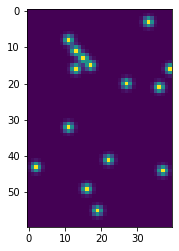

In [20]:
plt.imshow(valid_outputs[0])

In [3]:
from holodecml.data import load_unet_datasets_xy

gauss = "z"
input_col="image"

train_inputs,\
train_outputs,\
valid_inputs,\
valid_outputs = load_unet_datasets_xy(path_data,
                                      num_particles,
                                      output_cols,
                                      subset,
                                      bin_factor,
                                      input_col,
                                      gauss)


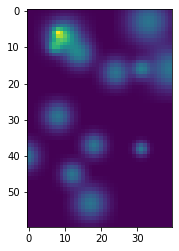

In [4]:
plt.imshow(valid_outputs[0])

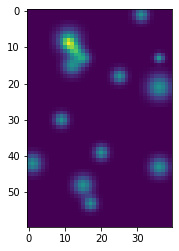

In [6]:
plt.imshow(valid_outputs[0])

In [ ]:
valid_outputs[0].shape